# Objective
Predict the price of a house

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing

# Data preparation

In [3]:
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)

(20640, 8) (20640,)


## Dataset description

In [4]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

# EDA

No empty record

In [7]:
data.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

- All columns are numeric, no need to handle categorical variables
- Need to figure out how best to use the coordinates

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


## Target variable (MedHouseVal) 
- A normal distribution thats skewed to the right/positive skewness. There are outlier values at the furthest right
- Need to normalize or scale the data
- **Skewness** focuses on the spread (tails) of normal distribution
- **Kurtosis** focuses more on the height. It tells us how peaked or flat our normal (or normal-like) distribution is

[Skewness and kurtosis](https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis)

<Axes: xlabel='MedHouseVal', ylabel='Count'>

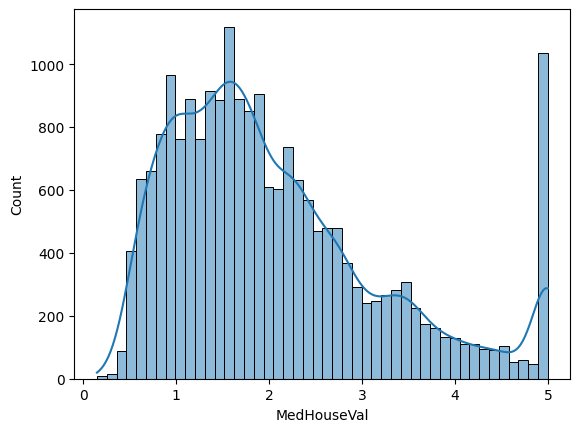

In [13]:
sns.histplot(target, kde=True)

<Axes: xlabel='MedHouseVal', ylabel='Count'>

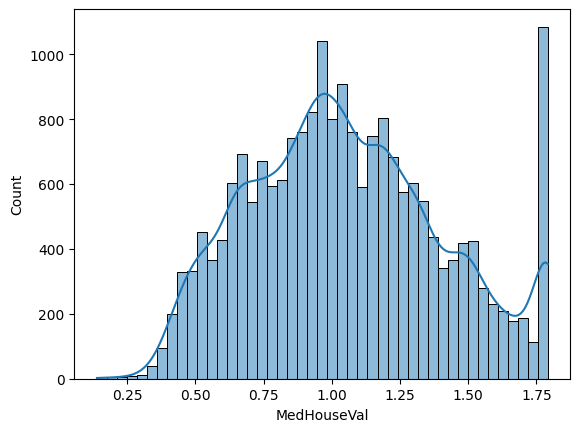

In [99]:
sns.histplot(np.log1p(target), kde=True) # log normalizes distribution

### Skewness and kurtosis

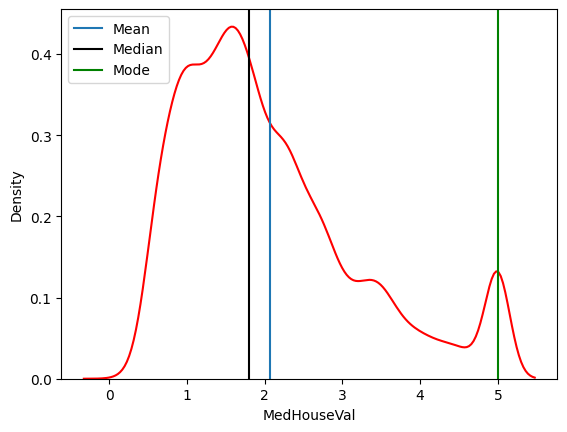

In [49]:
sns.kdeplot(target, color='red') # better than histogram as you don't have to worry about bin size, less noisy
plt.axvline(target.mean(), label="Mean")
plt.axvline(target.median(), color="black", label="Median")
plt.axvline(target.mode().values[0], color="green", label="Mode")
plt.legend()

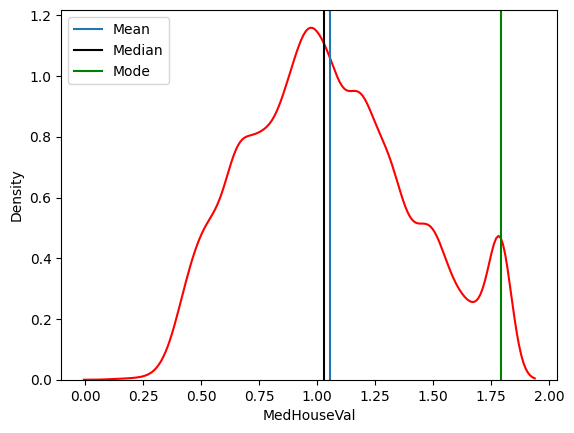

In [100]:
sns.kdeplot(np.log1p(target), color='red') # better than histogram as you don't have to worry about bin size, less noisy
plt.axvline(np.log1p(target).mean(), label="Mean")
plt.axvline(np.log1p(target).median(), color="black", label="Median")
plt.axvline(np.log1p(target).mode().values[0], color="green", label="Mode")
plt.legend()

- Median > mean and mode > greater than both
- It visually looks like its skewed to the right but we need to handle that outlier

In [29]:
print(f"Mean: {target.mean()}\nMedian: {target.median()}\nMode: {target.mode().values[0]}")

Mean: 2.068558169089147
Median: 1.797
Mode: 5.00001


In [35]:
print(f"Skewness is: {round(target.skew(), 1)} - highly skewed (positive)")

Skewness is: 1.0 - highly skewed (positive)


In [39]:
print(f"Kurtosis is: {round(target.kurtosis(), 1)} - platykurtic") # flat peak, light tails

Kurtosis is: 0.3 - leptokurtic


# Predictor variables

In [11]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

### Skewness and kurtosis

- 'AveRooms', 'AveBedrms', 'Population' and 'AveOccup' are positively skewed with high kurtosis (sharp peak)
- 'MedInc' is also positively skewed with high kurtosis but it isn't as sharp as the rest
- Hard to explain the distribution of 'HouseAge'

In [50]:
predictor_df = data[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']]
predictor_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


In [58]:
predictor_df.skew()

MedInc         1.646657
HouseAge       0.060331
AveRooms      20.697869
AveBedrms     31.316956
Population     4.935858
AveOccup      97.639561
dtype: float64

In [57]:
predictor_df.kurtosis()

MedInc            4.952524
HouseAge         -0.800629
AveRooms        879.353264
AveBedrms      1636.711972
Population       73.553116
AveOccup      10651.010636
dtype: float64

### Univariate analysis

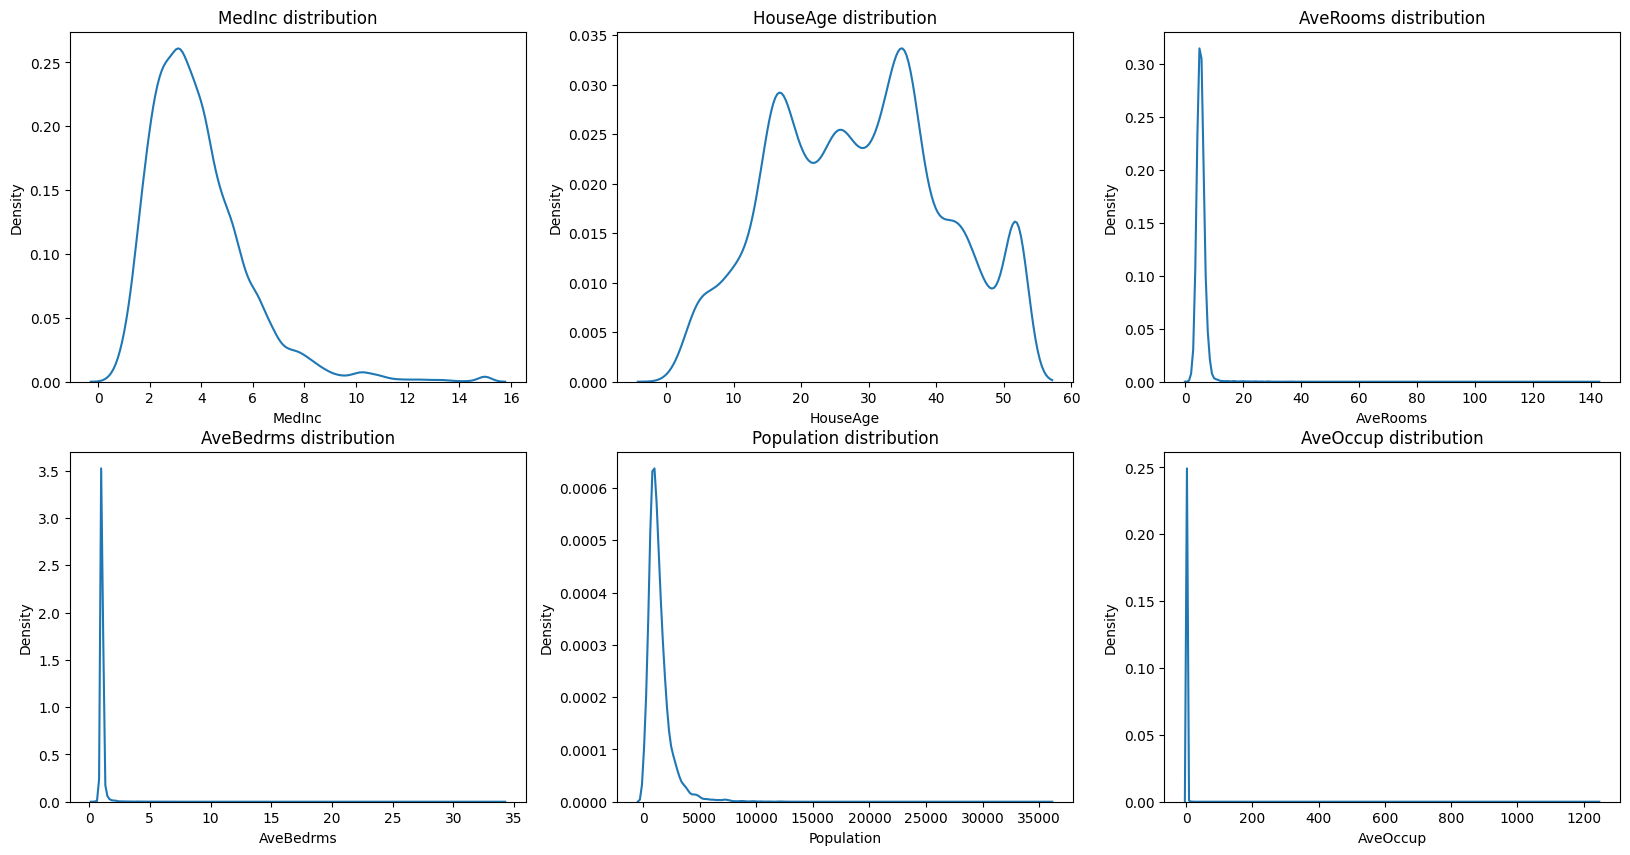

In [53]:
fix, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, col in enumerate(predictor_df.columns):
    sns.kdeplot(predictor_df[col], ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(f"{col} distribution")

Attribute Information:

    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

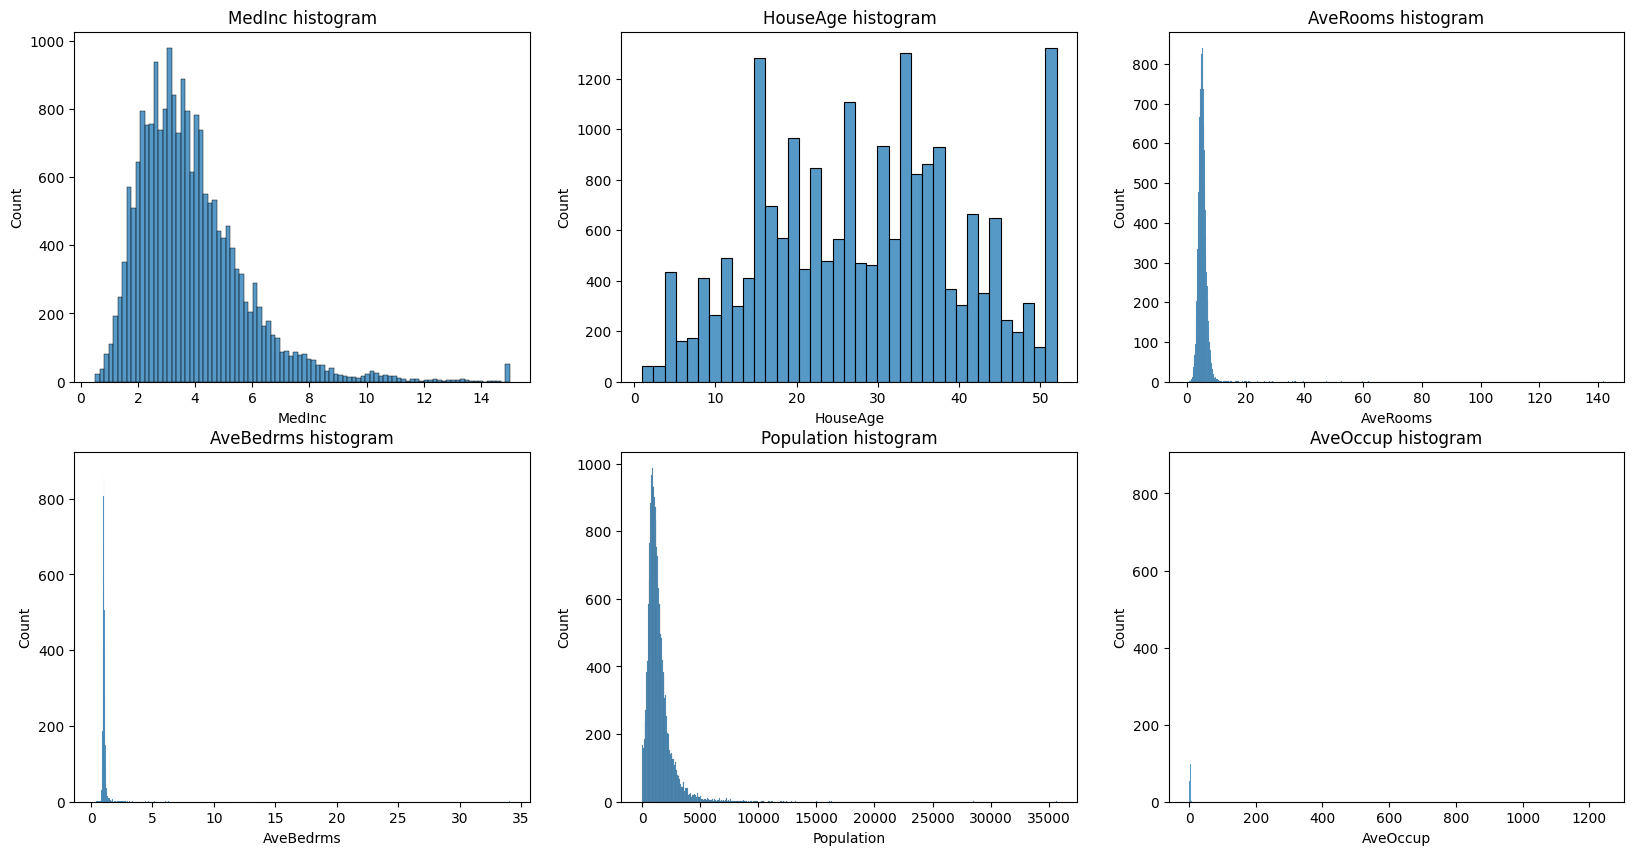

In [55]:
fix, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, col in enumerate(predictor_df.columns):
    sns.histplot(predictor_df[col], ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(f"{col} histogram")

## Visualize coordinates
- Houses closer to the beach are more expensive

In [116]:
from numpy import size


px.scatter_geo(data_frame=data, 
               lat=data.Latitude, 
               lon=data.Longitude, 
               color=target,
               scope='usa', 
               fitbounds='locations', 
               title='California Housing Prices')

## Bivariate analysis

In [70]:
combined_df = pd.concat([data, target], axis=1)
combined_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


- Positive linear relationship between MedHouseVal and MedInc. This makes intuitive sense, as areas with higher income often correlate with higher house values
- There is a slight positive trend where newer houses (HouseAge closer to 0) might have lower house values, and older houses seem to show a slight increase in house values. However, the scatter is quite dense, and the trend isn’t very strong
- Almost no relationship for the rest of the variables

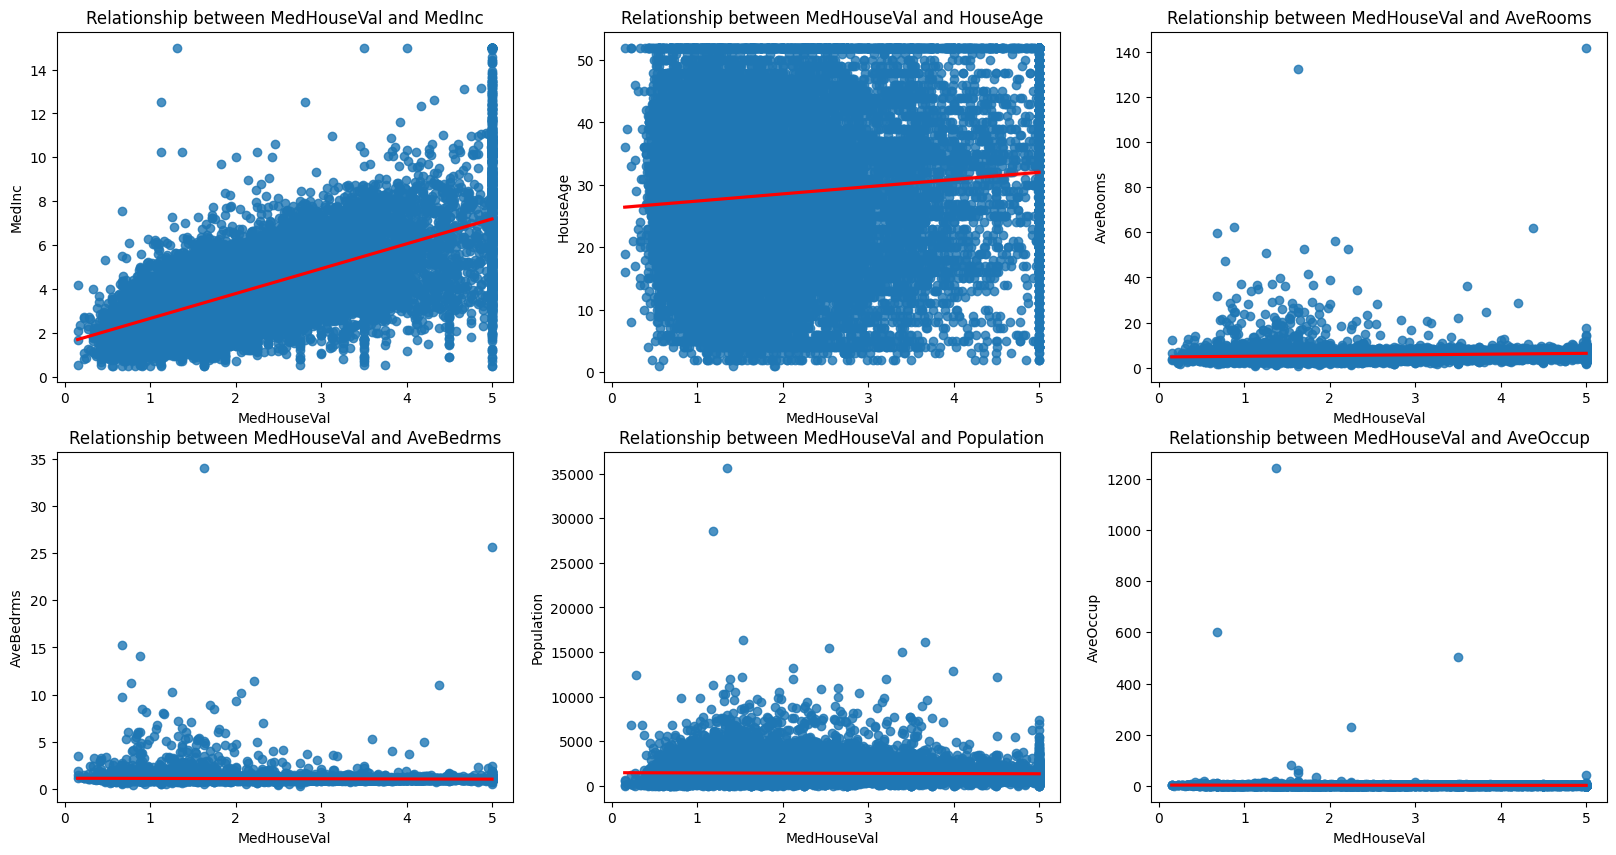

In [91]:
fix, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, col in enumerate(combined_df.columns[:-3]):
    # sns.scatterplot(data=combined_df, x="MedHouseVal", y=col, ax=ax[i//3, i%3])
    sns.regplot(data=combined_df, x="MedHouseVal", y=col, ax=ax[i//3, i%3], scatter=True, line_kws={"color":"red"})
    ax[i//3, i%3].set_title(f"Relationship between MedHouseVal and {col}")

#### AveRooms vs Population
- The houses with the most rooms have a block group population of 0, might it mean that they're hotels?
- There are 2 houses with very high block group population, they might be high rise properties

<Axes: xlabel='AveRooms', ylabel='Population'>

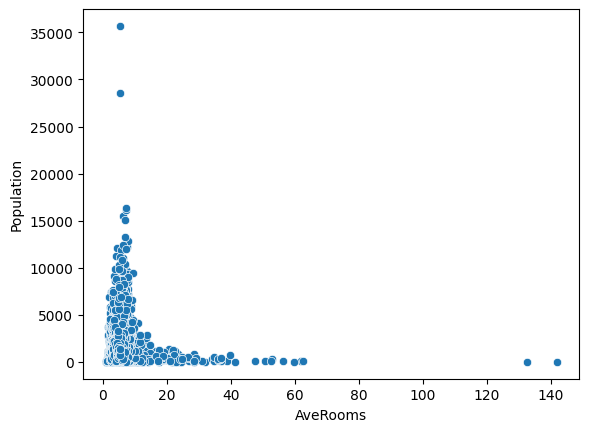

In [71]:
sns.scatterplot(x='AveRooms', y='Population', data=combined_df)

- Most of the expensive houses have less than 20 rooms
- The 2 densely populated houses are not very expensive
- The 2 houses with a lot of rooms; one is expensive the other is cheaper (high end and cheaper hotel?)

<Axes: xlabel='AveRooms', ylabel='Population'>

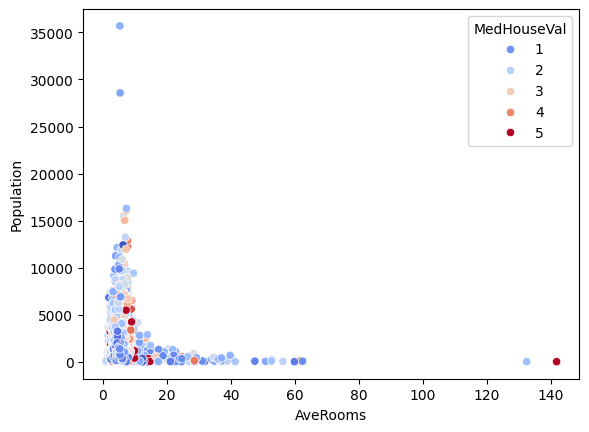

In [79]:
sns.scatterplot(x='AveRooms', y='Population', data=combined_df, hue='MedHouseVal', palette='coolwarm')

#### AveBedrms vs AveOccup
- No clear relationship

<Axes: xlabel='AveBedrms', ylabel='AveOccup'>

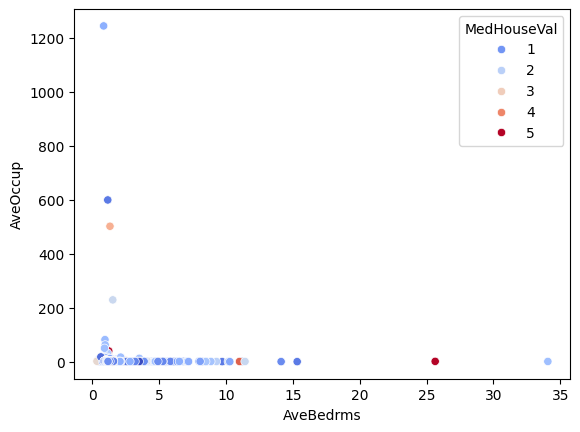

In [95]:
sns.scatterplot(x='AveBedrms', y='AveOccup', data=combined_df, hue='MedHouseVal', palette='coolwarm')

In [94]:
combined_df[combined_df['AveRooms'] > 100] # not certain what these houses are

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1914,1.875,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10,5.00001
1979,4.625,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.62500


#### AveRooms vs AveBedrms

- A positive linear relationship between number or rooms and number of bedrooms

<Axes: xlabel='AveRooms', ylabel='AveBedrms'>

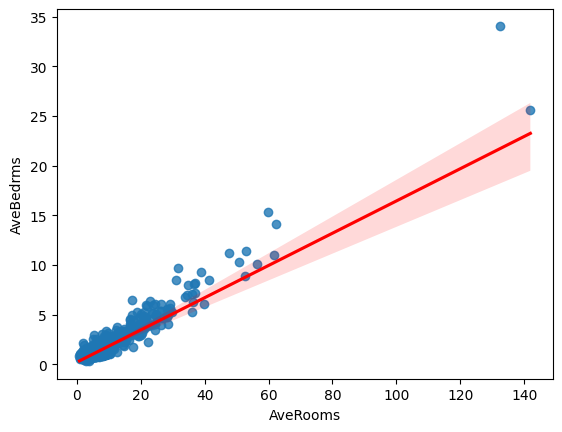

In [93]:
sns.regplot(x='AveRooms', y='AveBedrms', data=combined_df, scatter=True, line_kws={"color":"red"})

#### MedInc vs AveBedrms
No clear relationship

<Axes: xlabel='MedInc', ylabel='AveBedrms'>

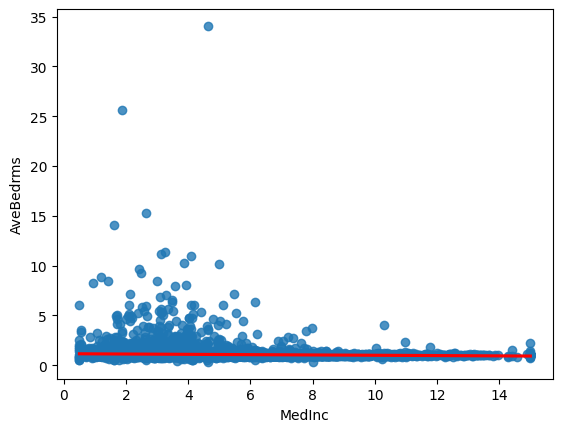

In [98]:
sns.regplot(x='MedInc', y='AveBedrms', data=combined_df, scatter=True, line_kws={"color":"red"})